In [1]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib
import numpy as np
import pandas as pd
plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix

C:\Users\aa271\AppData\Local\Temp\ipykernel_14996\1077775104.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle

In [3]:
data = pd.read_excel("dataDMLnoscale.xlsx", index_col=0)

In [4]:
columnnameen = ['Isoprene',
                '1,3-Butadiene',
                'Butene',
                'Pentene',
                'NOx',
                'O$_3$',
                'PM$_1$',
                'SO$_2$',
                'Radiation',
                'Temperature',
                'Humidity',
                'TICCLabel',
                'Month',
                'KMeansLabel']
columnname = [
    'Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene',
    'NOx',
    'O3',
    'PM1',
    'SO2',
    'Radiation',
    'Temperature',
    'Humidity',
    'TICCLabel',
    "Place",
    'Month',
    'KMeansLabel'
]

Xcolname = ['NOx',
            'O$_3$',
            'SO$_2$',
            'Radiation',
            'Temperature',
            'Humidity',
            ]

Tname = ['Isoprene',
         '1,3-Butadiene',
         'Butene',
         'Pentene']
yname = ['PM1']
Xname = ['NOx',
         'O3',
         'SO2',
         'Radiation',
         'Temperature',
         'Humidity', ]
Wname = ["Place",
         'Month',
         'KMeansLabel']
# data=pd.read_excel("dataDML.xlsx",index_col=0)
data.columns = columnname

In [5]:

# data=grouped_data
# data.columns=columnname
X = data[Xname]
T = data[Tname]
y = np.array(data[yname]).ravel()
Dummy = [pd.get_dummies(data[i], prefix=i, drop_first=True) for i in Wname]
W = pd.concat([Dummy[0], Dummy[1], Dummy[2]], axis=1)
# Combine W with X for predictions
X_combined = pd.concat([X, W], axis=1)
X_train_combined, X_test_combined, y_train, y_test, T_train, T_test = train_test_split(X_combined, y, T, test_size=0.2,
                                                                                       random_state=42)
from sklearn.preprocessing import StandardScaler

# Define the columns that need to be standardized
columns_to_scale = Xname

# Separate out the parts of X_combined that need to be standardized
X_to_scale = X_train_combined[columns_to_scale]
X_test_to_scale = X_test_combined[columns_to_scale]

# Initialize the scaler and fit it to the training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Convert scaled arrays back to DataFrame for concatenation
X_scaled_df = pd.DataFrame(X_scaled, columns=columns_to_scale, index=X_to_scale.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale, index=X_test_to_scale.index)

# Replace the original columns in X_combined with the scaled ones
X_train_combined[columns_to_scale] = X_scaled_df
X_test_combined[columns_to_scale] = X_test_scaled_df

In [6]:
import pickle

with open('bayes_search_results_y.pkl', 'rb') as file:
    bayes_search_results_y = pickle.load(file)
with open('bayes_search_results_t.pkl', 'rb') as file:
    bayes_search_results_t = pickle.load(file)
with open('mse_results.pkl', 'rb') as file:
    mse_results = pickle.load(file)
# 找到最佳模型的名称和实例
best_model_y_name = min((k for k in mse_results if 'model_y' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_y'])
best_model_t_name = min((k for k in mse_results if 'model_t' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_t'])

best_model_y = bayes_search_results_y[best_model_y_name].best_estimator_
best_model_t = bayes_search_results_t[best_model_t_name].best_estimator_

print(f"Best model_y name: {best_model_y_name}")
print(f"Best model_t name: {best_model_t_name}")
print("Best model_y instance:", best_model_y)
print("Best model_t instance:", best_model_t)

Best model_y name: GradientBoostingRegressor
Best model_t name: GradientBoostingRegressor
Best model_y instance: Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.10422385851639915,
                                           max_depth=8, max_features='sqrt',
                                           n_estimators=500, subsample=0.5))])
Best model_t instance: Pipeline(steps=[('model',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.07007568334197407,
                                                                          max_depth=8,
                                                                          max_features='sqrt',
                                                                          n_estimators=500,
                                                                          subsample=0.5351680873953943)))])


In [7]:
import shap

In [17]:
model=best_model_y.named_steps['model']
explainer = shap.TreeExplainer(model)
shap_values= explainer(X_train_combined)

In [12]:
feature_names=['NO$_x$','O$_3$','SO$_2$', 'Radiation', 'Temperature', 'Humidity', 'Place_jh',
       'Month_Jul', 'Month_Jun', 'KMeansLabel_1', 'KMeansLabel_2',
       'KMeansLabel_3']

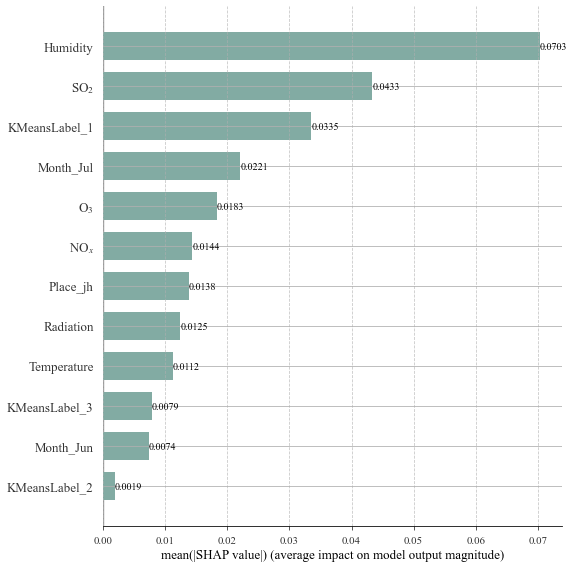

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.sca(ax)
shap.summary_plot(shap_values, X_train_combined, plot_type="bar", feature_names=feature_names, show=False, color='#82ABA3', plot_size=(8, 8))
plt.grid(axis='x',linestyle='--',alpha=0.7)
plt.grid(axis='y')


# Add labels to the horizontal bar plot
bars = [rect for rect in ax.get_children() if isinstance(rect, plt.Rectangle)]

for bar in bars[:-1]:  # The last rectangle is the background
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 4), ha='left', va='center', fontsize=10)
plt.savefig("重要程度SOA.svg", bbox_inches='tight')

In [9]:
explainers = []
shap_values_list = []
model=best_model_t.named_steps['model']
# 遍历每个估计器
for estimator in model.estimators_:
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(X_train_combined)
    explainers.append(explainer)
    shap_values_list.append(shap_values)

In [11]:
import joblib
joblib.dump(shap_values_list,"shap_values_list.pkl")

['shap_values_list.pkl']

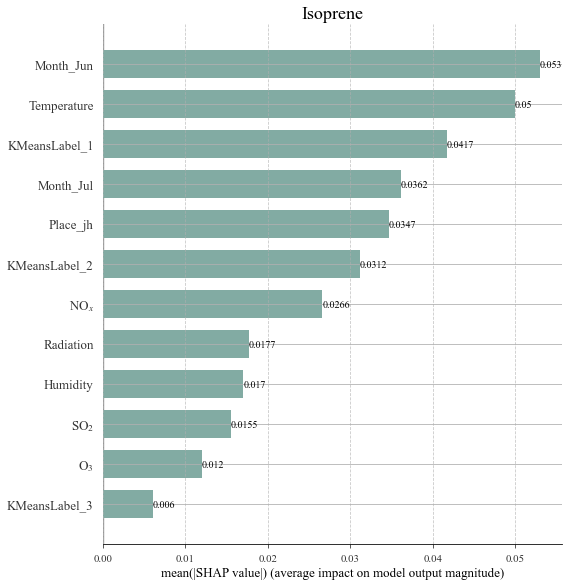

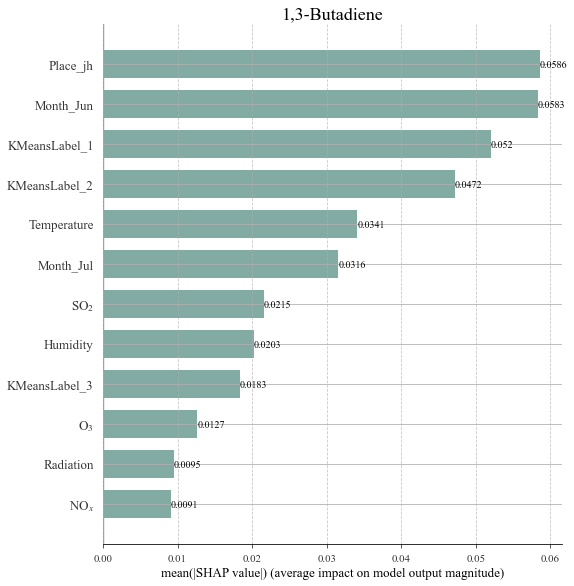

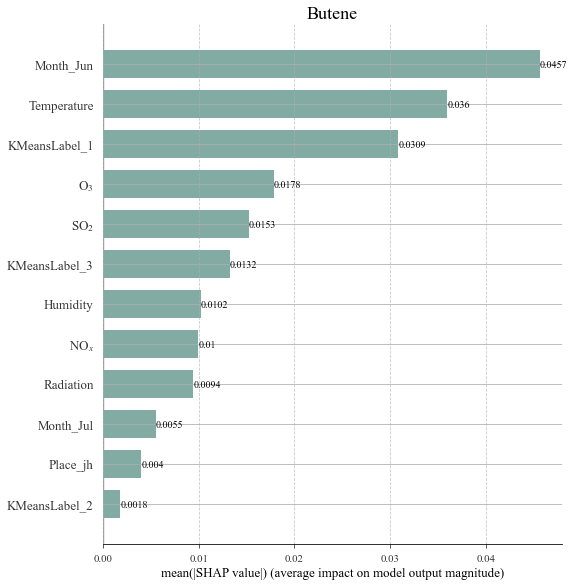

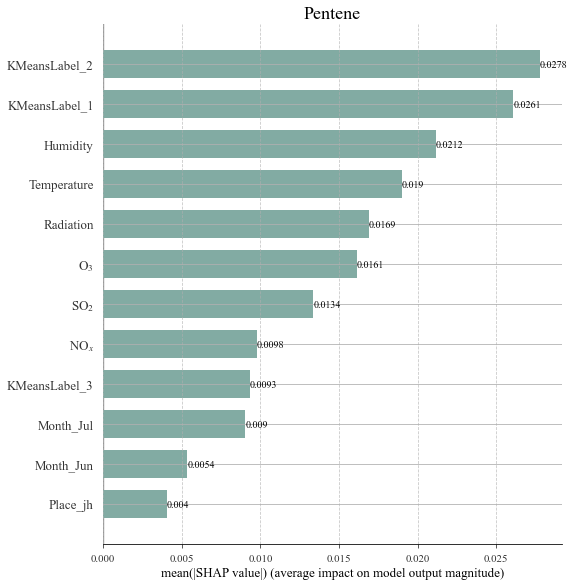

In [15]:
for i, shap_values in enumerate(shap_values_list):
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    plt.sca(ax)
    shap.summary_plot(shap_values, X_train_combined, plot_type="bar", feature_names=feature_names, show=False, color='#82ABA3', plot_size=(8, 8))
    plt.title(Tname[i], fontsize=18)
    plt.grid(axis='x',linestyle='--',alpha=0.7)
    plt.grid(axis='y')

    # Add labels to the horizontal bar plot
    bars = [rect for rect in ax.get_children() if isinstance(rect, plt.Rectangle)]
    for bar in bars[:-1]:  # The last rectangle is the background
        xval = bar.get_width()
        plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 4), ha='left', va='center', fontsize=10)

    plt.savefig(f"重要程度BVOCs_{Tname[i]}.svg", bbox_inches='tight')
    plt.show()